In [31]:
# -*- coding: utf-8 -*-
import os
import time
import ogr2ogr
import shapely.geometry as sgeom
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import numpy as np
from fiona.errors import DriverError
from fiona.drvsupport import supported_drivers
from configparser import ConfigParser
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# 為cartpy0.17bug暫時添加
import six
from PIL import Image



file_shp 發現檔案:
台灣_縣市界線

file_csv 發現檔案:
氣象測站

file_kml 發現檔案:
markchoo-mountain-wpt-0100

讀取檔案: 台灣_縣市界線.shp
原座標系統： +init=epsg:4326 +type=crs
轉換為： epsg:4326
  COUNTYID COUNTYCODE COUNTYNAME          COUNTYENG  \
0        Z      09007          蝮  Lienchiang County   
1        G      10002       摰蝮       Yilan County   
2        N      10007        敶啣蝮    Changhua County   
3        M      10008         蝮      Nantou County   
4        P      10009         脫蝮      Yunlin County   

                                            geometry  
0  MULTIPOLYGON (((119.96445 25.94552, 119.96427 ...  
1  MULTIPOLYGON (((121.95971 24.84494, 121.96064 ...  
2  POLYGON ((120.45655 24.20719, 120.48589 24.197...  
3  POLYGON ((121.27086 24.23661, 121.27108 24.236...  
4  MULTIPOLYGON (((120.08108 23.52412, 120.08161 ...  

讀取檔案: 氣象測站.csv
原座標系統： +init=epsg:4326 +type=crs
轉換為： epsg:4326
  Station_num Station_name       Lon      Lat COUNTYNAME field_6  \
0      466850       五分山雷達站  121.7812  25.0712       

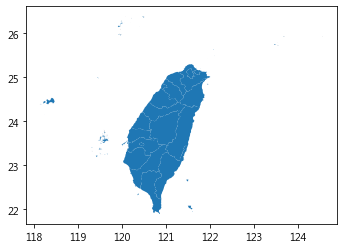

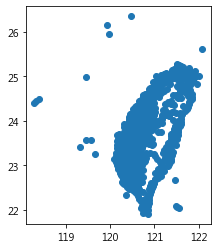

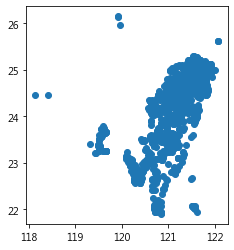

In [32]:
read_files = []
read_colors = []
file_set = []
df_set = []
color_set = []
i = 0
# 副檔名
ext = []
# 建立傳給gp.read_file的額外參數 (csv用)
options = {}
cfg = ConfigParser()
cfg.read('config.ini', encoding='utf-8-sig')
# 由ini讀入各格式檔名
for section in cfg.sections():
    read_files.append(cfg[section]['name'])
    read_colors.append(cfg[section]['color'])
    if read_colors[i] != "":
        cs = read_colors[i].split(',')
        for c in cs:
            c.strip()
            color_set.append(c)
    i += 1
    ext.append(section.split('file_')[1])
    print("\n{} 發現檔案:".format(section))
    for temp in read_files[cfg.sections().index(section)].split(','):
        print(temp.strip()) if temp != "" else print("沒有發現任何檔案")

i = 0
try:
    # 讀檔
    for files in read_files:
        if files != "":
            # 重置參數
            options = {}
            # 分割當前種類檔名
            fs = files.split(',')
            for f in fs:
                # 去除空白
                f = f.strip()
                file_set.append("{}.{}".format(f,ext[i]))
                # shp檔
                if ext[i] == 'shp':
                    pass
                # csv檔
                elif ext[i] == 'csv':
                    # 啟用指定的fiona驅動
                    # 參見: https://gdal.org/drivers/vector/index.html
                    supported_drivers['CSV'] = 'rw'
                    # 指定經緯度參數的欄位名稱
                    # 參見: https://gdal.org/drivers/vector/csv.html#reading-csv-containing-spatial-information
                    options['X_POSSIBLE_NAMES']='Lon'
                    options['Y_POSSIBLE_NAMES']='Lat'
                # kml檔
                elif ext[i] == 'kml':
                    # kml轉shp shp檔存在input之當前檔名資料夾下
                    out_path = "./input/{}".format(f)
                    out_name = "{}/{}.shp".format(out_path,f)
                    if not os.path.exists(out_path):
                        os.mkdir(out_path)
                    ogr2ogr.main(["","-f", "ESRI Shapefile", out_name, "./input/{}.kml".format(f),
                                  "-dim", "2",
                                  "-lco", "ENCODING=UTF-8"])
                    #supported_drivers['libkml'] = 'rw'
                    #supported_drivers['LIBKML'] = 'rw'
                    #options['driver']='KML'

                print("\n讀取檔案: {}.{}".format(f, ext[i]) )
                if ext[i] != 'kml':
                    df = gp.read_file("./input/{}.{}".format(f, ext[i]), encoding='utf-8', **options)
                else:
                    df = gp.read_file(out_path, encoding='utf-8')
                df.crs = {'init' :'epsg:4326'} # 避免input沒給 這邊給預設值(WGS84)
                print("原座標系統： {}".format(df.crs))
                # 座標轉換
                df = df.to_crs(epsg=4326)
                print("轉換為： {}".format(df.crs))

                # 只取geometry
                #search = u"臺北市"
                #df = df[df['COUNTYNAME'].isin(["臺北市"])]
                print(df.head())
                #df = df[['COUNTYNAME','geometry']]
                df = df[['geometry']]
                df.reset_index(drop=True)
                df_set.append(df)
                df.plot()
        i += 1
except DriverError:
    print("無法讀取檔案: {}!".format(f))

In [33]:
# 迭代各dataframe 回傳經緯度min/max (minx/miny/maxx/maxy)
bound = [9999, 0, 9999 , 0] # 預設值
for df in df_set:
    bounds = df.geometry.bounds
    # 檢查各值 符合條件(更大的框)則更新
    bound = [min(bounds.minx) if min(bounds.minx)<bound[0] else bound[0], # 最小經度
             max(bounds.maxx) if max(bounds.maxx)>bound[1] else bound[1], # 最大經度
             min(bounds.miny) if min(bounds.miny)<bound[2] else bound[2], # 最小緯度
             max(bounds.maxy) if max(bounds.maxy)>bound[3] else bound[3]] # 最大緯度
margin_lng = (bound[0] - bound[1]) * 0.03
margin_lat = (bound[2] - bound[3]) * 0.03
#bound = list(map(lambda x, y: x + y, bound, [-margin_lng, +margin_lng, -margin_lat, +margin_lat]))
print(bound)

[118.13669, 124.56114950000006, 21.895599675000085, 26.385278130000074]


In [34]:
def new_get_image(self, tile):
    if six.PY3:
        from urllib.request import urlopen, Request
    else:
        from urllib2 import urlopen
    url = self._image_url(tile)  # added by H.C. Winsemius
    req = Request(url) # added by H.C. Winsemius
    req.add_header('User-agent', 'your bot 0.1')
    # fh = urlopen(url)  # removed by H.C. Winsemius
    fh = urlopen(req)
    im_data = six.BytesIO(fh.read())
    fh.close()
    img = Image.open(im_data)

    img = img.convert(self.desired_tile_form)

    return img, self.tileextent(tile), 'lower'

In [35]:
def getBoundsZoomLevel(bound, mapDim):
    WORLD_DIM = { "height": 256,
                  "width": 256 }
    ZOOM_MAX = 20

    def latRad(lat) :
        sin = math.sin(lat * math.pi / 180)
        radX2 = math.log((1 + sin) / (1 - sin)) / 2
        return max(min(radX2, math.pi), -math.pi) / 2

    def zoom(mapPx, worldPx, fraction):
        return math.floor(math.log(mapPx / worldPx / fraction) / math.log(2))
    # 計算採用googlemap格式 (緯度,經度)
    # 右上
    ne = {"lat": bound[3],
          "lng": bound[1]}
    # 左下
    sw = {"lat": bound[2],
          "lng": bound[0]}

    latFraction = (latRad(ne["lat"]) - latRad(sw["lat"])) / math.pi

    lngDiff = ne["lng"] - sw["lng"]
    lngFraction = ((lngDiff + 360) / 360) if lngDiff < 0 else (lngDiff / 360)

    latZoom = zoom(mapDim["height"], WORLD_DIM["height"], latFraction)
    lngZoom = zoom(mapDim["width"], WORLD_DIM["width"], lngFraction)

    return min(latZoom, lngZoom, ZOOM_MAX)

計算最佳zoom_level:  8
耗時11.0秒


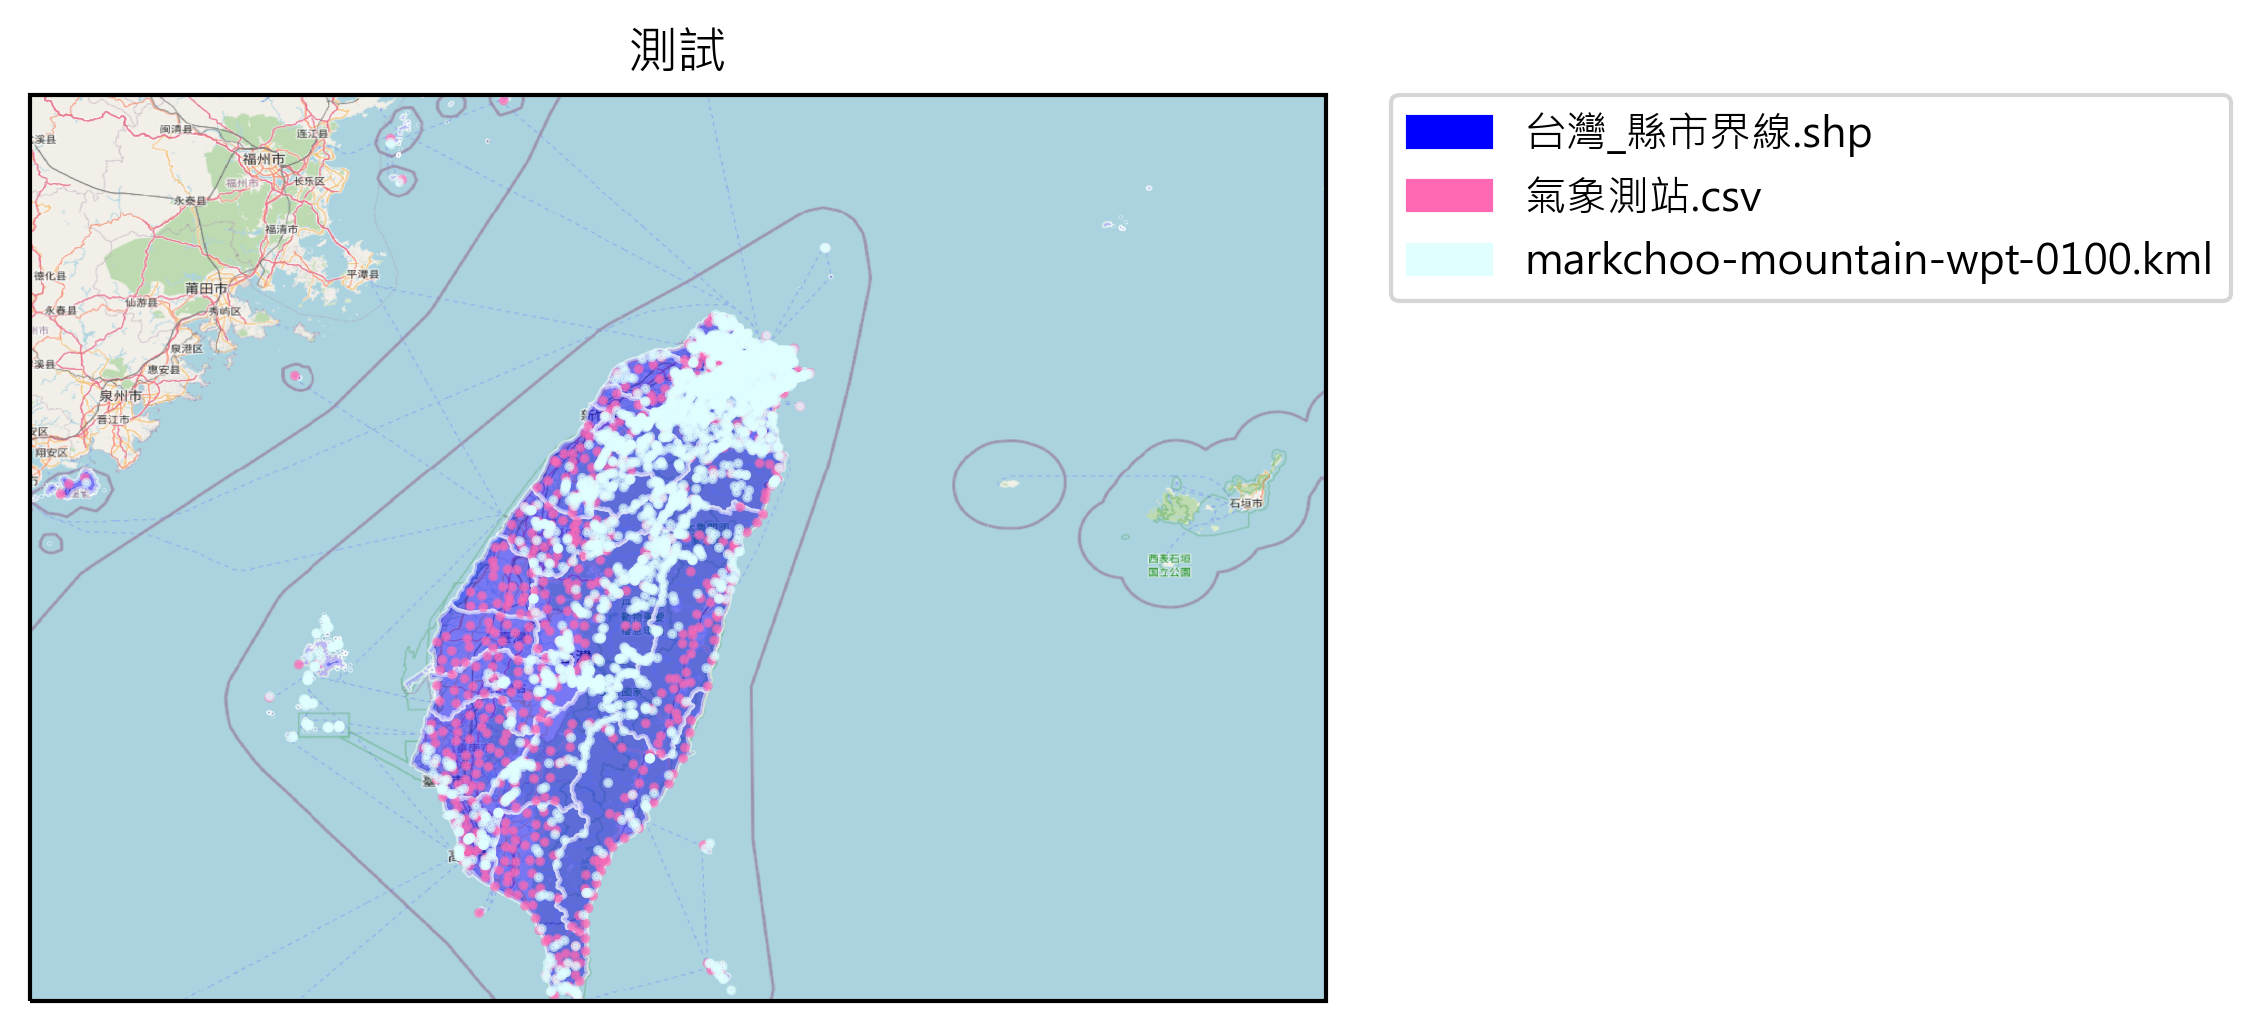

In [36]:
# fig與legend固定4比1
# 字體大小12pt
# legend超出則裁切
# 解決matplotlib本身不支援中文字體 會顯示成方塊的問題
# 參見： https://stackoverflow.com/questions/10960463/non-ascii-characters-in-matplotlib
plt.rcParams['axes.unicode_minus'] = False # 解決負號 '-' 顯示為方塊的問題
plt.rc('font', **{'sans-serif' : 'Microsoft JhengHei', # 指定中文字體 (微軟正黑體)
                  'family' : 'sans-serif'}) # 指定默認字型
dpi = 300
fig = plt.figure(dpi=dpi)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_title("測試")
ax.set_extent(bound, ccrs.PlateCarree())
# 獲取fig框像素大小
fig_size = fig.get_size_inches()*fig.dpi
mapDim = { "height": int(fig_size[0]),
           "width":  int(fig_size[1])}
# 計算zoom_level
zoom_lv = getBoundsZoomLevel(bound, mapDim)
print("計算最佳zoom_level: ", zoom_lv)

OSM.get_image = new_get_image
imagery = OSM()

# interpolation: matplotlib抗鋸齒
# 待0.18.1發佈更新 可修正下述bug
# cartopy0.18版interpolation有bug
# 參見: https://github.com/SciTools/cartopy/issues/1563
# cartopy0.17版add_image有bug
# 參見: https://github.com/SciTools/cartopy/issues/1341
'''
target = sgeom.box(bound[0], bound[2], bound[1], bound[3])
target_mercator = imagery.crs.project_geometry(target, ccrs.Geodetic()).geoms[0]
for i in range(zoom-3, zoom+4):
    req_tiles = len(list(imagery.find_images(target_mercator, i)))
    print("zoom:{}, 需要{}個圖塊".format(i, req_tiles))
'''

inter = 'spline36'
# regrid_shape: basemap長寬之短邊尺寸
regrid = max(mapDim.values())
#ax.add_image(imagery, zoom, interpolation=inter, regrid_shape=regrid)
ax.add_image(imagery, zoom_lv, regrid_shape=regrid)
# 色碼表： https://www.ebaomonthly.com/window/photo/lesson/colorList.htm
#cmap = plt.get_cmap('Paired')
#colors = cmap(np.linspace(0,1, len(file_set)))
patchs = []
for label, color, df in zip(file_set, color_set, df_set):
    if sum(df.geom_type == 'Point') != 0:
        ax.scatter([point.x for point in df.geometry],
                   [point.y for point in df.geometry],
                   s=[2 for i in range(len(df.geometry))], # s = size:控制每個點大小的list
                   c=color,
                   alpha=0.6,
                   transform=ccrs.PlateCarree(),
                   zorder=2) # Zorder:大的在上面 預設為先畫的在上面
    elif sum(df.geom_type == 'MultiPoint') != 0:
        for points in df.geometry:
            ax.scatter([point.x for point in points],
                       [point.y for point in points],
                       s=[2 for i in range(len(df.geometry))],
                       c=color,
                       alpha=0.6,
                       transform=ccrs.PlateCarree(),
                       zorder=2)
    else: # polygon
        c='blue'
        # add_geomrtries把資料視為polygon匯入 若是point add後會沒有東西
        ax.add_geometries(df.geometry,
                          ccrs.PlateCarree(),
                          edgecolor='white',
                          facecolor=color,
                          alpha=0.5,
                          zorder=1)
    # plt.plot的圖例可指定實例讓handles自動生成
    # add_geometries的圖例需透過mpatches.Patch
    patchs.append(mpatches.Patch(color=color,
                                 label=label))

lg = plt.legend(handles=patchs,
                bbox_to_anchor=(1.05, 1), # (0,0):座標軸左下角 ; (1,1):座標軸右上角
                loc='upper left',
                borderaxespad=0.
                )
st = time.time()
plt.savefig('./output/result.jpg',
            dpi=dpi,
            # !
            # 防止圖例框轉圖像時被裁剪
            bbox_extra_artists=(lg,),
            bbox_inches='tight')
et = time.time() - st
print("耗時{:.1f}秒".format(et))
plt.show()